# Exploring and Pre-Processing the Chess Dataset

In this Jupyter notebook, we will be exploring this [Kaggle chess dataset](https://www.kaggle.com/ronakbadhe/chess-evaluations) of Stockfish evaluations.

*Note:* This Jupyter notebook will not run properly unless you have the `.csv` files downloaded off the link above. I placed the files in a directory called `data` under the directory that this Jupyter notebook is in.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import chess
import chess.svg

Let's start by loading all the data using `pandas`.

In [3]:
data_path = os.path.join('data', 'chessData.csv')

df = pd.read_csv(data_path)
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


## FEN Strings

The first string is labeled FEN, so I assume they represent chess positions. A quick Google search reveals that these are in [Forsyth-Edwards Notation](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation).

Here's an example of a FEN string:
`3rr1k1/1pq1bppp/pnp1p3/3pP3/1P1B1P2/P3P2P/3NQ1P1/2R2RK1 w - - 3 22`. Let's load it as a board and see what's going on here.

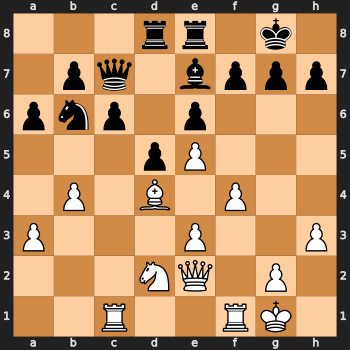

In [5]:
board = chess.Board('3rr1k1/1pq1bppp/pnp1p3/3pP3/1P1B1P2/P3P2P/3NQ1P1/2R2RK1 w - - 3 22')

chess.svg.board(board, size=350)

### Board State Encoding

In a FEN string, it appears that the portion before the first space encodes the board state: each of the eight pieces between slashes denotes a single row. Lowercase letters appear to denote black pieces while uppercase letters denote white pieces, and the letters map under standard chess notation:
* **K**ing
* **Q**ueen
* **R**ook
* **B**ishop
* k**N**ight
* **P**awn

Note that we have an awkward use of **N** for Knight instead of **K**, since that's taken up already by the king. In each row, letters represent black or white pieces, while numbers represent the number of empty squares between them. 

For example, the third row of the board is `pnp1p3`, so we should expect a black pawn, a black knight, a black pawn, an empty space, a black pawn, and then three empty spaces, in that order. And that is precisely what we see on the third row (6th rank) of the chess board above.

Ok, but what about the rest of the stuff after the board encoding? 

### Castling Rights

Well, the next letter can be either `w` or `b`, representing whose turn it is. After that, we have castling rights. For examples, the starting position for a chess game is `rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1`. Notice for the castling rights space we have `KQkq`. Once again, capital letters represent white pieces while lowercase letters represent black pieces, so `K` represents ability for white to kingside castle, `Q` represents ability for white to queenside castle, etc. 

### En Passant Captures

After that, we have [en passant](https://en.wikipedia.org/wiki/En_passant) capture opportunities. For example, after `e4` in a simple game the FEN is `rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1` (board shown below). Note that since the white e pawn moved two squares forward, it is possible to en passant capture the pawn that moved two squares by taking on `e3` (marked by an X below). Therefore, `e3` is written in the en passant capture space of the FEN string (even though clearly no black pawn is in position to actually perform the en passant capture).

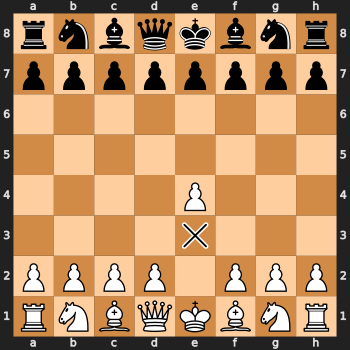

In [7]:
board = chess.Board('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1')
squares = [chess.E3]

chess.svg.board(board, squares=squares, size=350)

The rest of the FEN string isn't too important. For the curious, the next number is the halfmove clock, the number of halfmoves since the last capture or pawn advance, used for the fifty-move draw rule (i.e. the game is a draw after fifty moves without capture or pawn advance). The final number is simply the full-move counter, starting at 1 and incrementing after any move by Black.

## Converting the FEN String for Modeling

Converting the board into something that the model can run on is very important. There are two general ways to do this: a board-centric encoding and a piece-centric encoding. The first focuses one-hot encodes each piece within the 64 squares of a board and passes them in together, while the second uses different 8x8 layers for each piece, with 1s for where those pieces are (and 0s everywhere else).

I chose to use a piece-centric model, also with attack maps. The turn and castling rights are also encoded as entire 8x8 channels of 0s or 1s. I decided to ignore the en passant and turn counters since they didn't feel too important for the model.

More details on how I did this can be found in this [Python file](https://github.com/huskydj1/CarissaBot/blob/main/model/data_manip.py).

## Evaluation

Alright, let's look at the evaluations now. Most of them appear to be centipawn advantages of the position, with `+` when White is winning and `-` when Black is winning. 

By examining the `.csv` files, we can notice that there are some evaluations that start with `#`. It turns out that these are positions where one side can checkmate the other side immediately. 

Let's go ahead and convert these all to pawn advantage numbers, converting anything that starts with `#+` to something greater than the maximum of the dataset, and anything that starts with `#-` to something less than the minimum. The following code I wrote does this (which is also found in my [`data_manip.py`](https://github.com/huskydj1/CarissaBot/blob/main/model/data_manip.py) file).

In [8]:
def eval_to_pawn(eval):
    try:
        res = int(eval)
    except ValueError:
        res = 10000 if eval[1] == '+' else -10000

    res = min(res, 10000)
    res = max(res, -10000)
    return res/100

After doing this, we can apply this to the dataset and then plot a histogram.

In [9]:
df['Evaluation'] = df['Evaluation'].apply(eval_to_pawn)

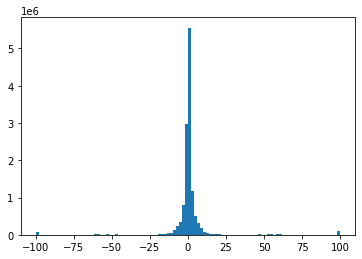

In [13]:
plt.hist(df['Evaluation'], bins=100)
plt.show()

Alright, this seems pretty reasonable and normal! The two other files that come on the chess dataset are `random_evals.csv` and `tactic_evals.csv`. We will be ignoring `tactic_evals.csv`, since we want our bot to develop a general understanding of how good positions are in chess, not to struggle with random sharp tactical combinations that come with particular piece placements, evaluations that probably won't generalize well. 

`random_evals.csv`, however, is very valuable, since the random moves will teach the model about moves that really suck. Indeed, we noticed that when we just trained on `chessData.csv`, a bot running the model would often make ridiculous sacrifices or other terrible moves, likely since nothing in the data told the model that these positions were bad. After training with `random_evals.csv`, however, it appeared to perform better.